In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 高斯混合模型

如果数据分离性好，那么用kmeans是很容易分的 

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples = 400, centers = 4,
                      cluster_std=0.6, random_state=0)
X = X[:,::-1]

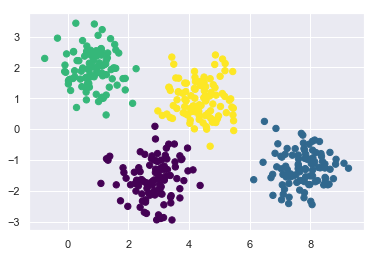

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap = 'viridis')

k-means 中的聚类，其实可以看做是以各个簇为中心画了一个圆,kmeans没有办法形成椭圆形的簇，因为没有权重方面的考虑    
两圆相交的部分，在不同的初始点的kmeans中是可能被分到不同簇的，这就导致结果的不确定性

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_cluster=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # 画出k-means模型的表示
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() for i,center in enumerate(centers)]
    for c,r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r,fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        

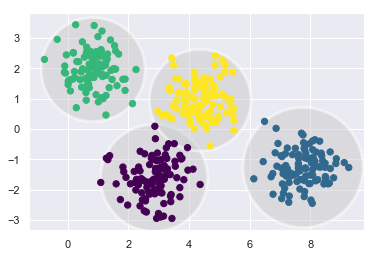

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

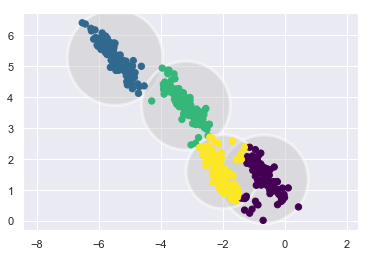

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

可以看到当数据簇有重合的时候，数据判断就会有误，这里黄色和紫色就无法准确的判断（分隔面还是线性的）

## 一般化 EM：高斯混合模型

一个高斯混合模型，试图找到多维高斯概率分布的混合体，从而获得任意数据集最好的模型。在最简单的场景中，GMM可以用于 k-means 相同的方式寻找类

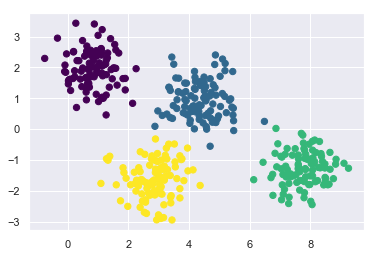

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis')

GMM 想象每个类别每个维度的数据都符合一个特定的高斯分布，如此一来，可以对单个点计算属于某个簇的概率，从而确定更属于哪个簇

从效果看，在简单的场景中，kmeans能分类好的数据，GMM也可以，因为GMM其实相当于给每个簇画椭圆

In [8]:
# 属于某个簇的概率
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.537 0.463 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


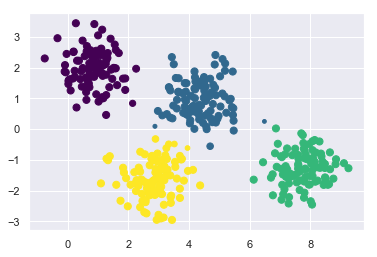

In [9]:
size = 50 * probs.max(1) ** 2  # 平方强调差异
plt.scatter(X[:, 0], X[:, 1], c = labels, cmap = 'viridis', s = size)

* 选择初始簇的中心位置和形状
* 重复以下步骤直到收敛
    * 期望步骤： 为每个点找到对应每个簇的概率作为权重
    * 更新每个簇的位置，将其标准化，并且基于所有数据点的权重来确定形状

同样这个算法有时并不是全局最优解，因此在实际应用中需要使用多个随机初始解

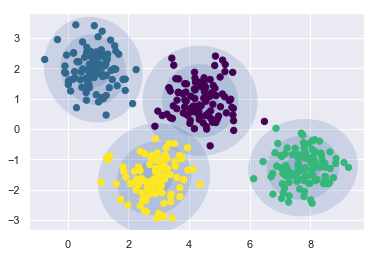

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转化为主轴
    if covariance.shape == (2,2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0],U[0,0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 画出椭圆
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                            angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha = w * w_factor)

gmm = GaussianMixture(n_components=4, random_state = 42)
plot_gmm(gmm, X)

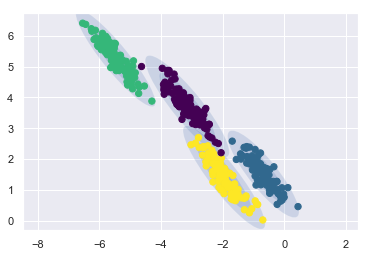

In [11]:
gmm = GaussianMixture(n_components=4, random_state = 42,covariance_type='full')
plot_gmm(gmm, X_stretched)

* 超参数：covariance_type
    * diag: 椭圆边界的主轴将与坐标轴平行
    * spherical: 约束簇的形状，让所有维度相等，就会变成圆
    * full: 允许每个簇在任意方向上用椭圆建模

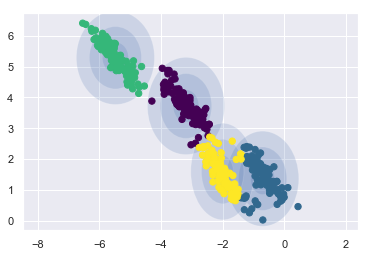

In [12]:
gmm = GaussianMixture(n_components=4, random_state = 42,covariance_type='diag')
plot_gmm(gmm, X_stretched)

## 将 GMM 用作密度估计

本质上是一个密度估计算法，是用来描述数据分布的生成概率模型

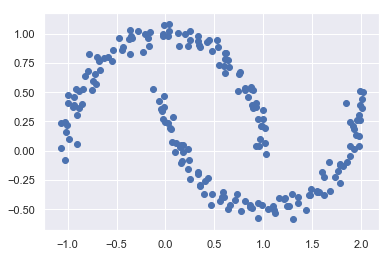

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

对于以上的非椭圆数据，自然直接聚类也是不好的

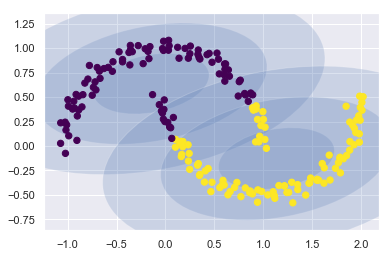

In [14]:
gmm2 = GaussianMixture(n_components = 2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

但是如果我们不关注成分，忽视簇标签的话，就可以找到一个更接近输入数据的拟合结果

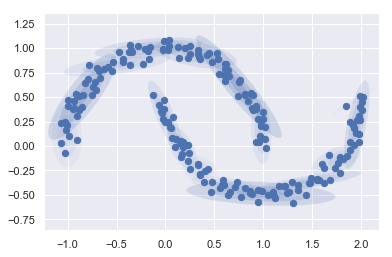

In [15]:
gmm16 = GaussianMixture(n_components = 16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

接着就可以利用这个密度生成器，获得新的数据

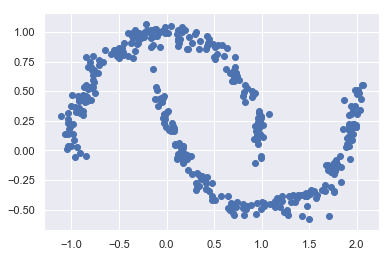

In [16]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:,0], Xnew[:,1])

GMM 是一种非常方便的建模方法，他可以为数据估计出任意维度的随机分布   
可以通过AIC， BIC 来两种度量准则来最终决定用什么维度

Text(0.5, 0, 'n_components')

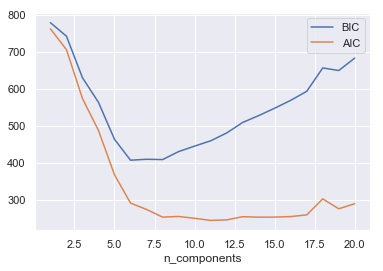

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components')

AIC告诉我们： 8-12个相对都比较优，但是再往后16个就比较多了  
BIC相对推荐了一个比较简单的模型，仅仅要求6-7的时候

## 用GMM生成新的数据

利用GMM和标准手写数字库生成新的手写数字。

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

画出前 100 个数据，看看这些数据

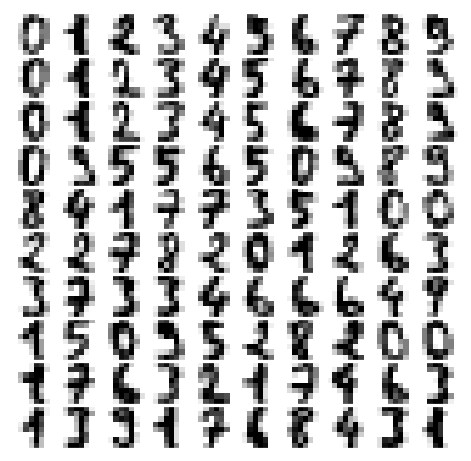

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8,8),
                          subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

一个数据有64维空间， GMM在这样一个高维空间中，可能不太容易收敛，所以会先用降维的方法实现降维。  
这里使用PCA

In [20]:
from sklearn.decomposition import PCA

pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

降维降到了41维且几乎没有信息损失，再对这个投影数据使用AIC，从而得到GMM成分数量的粗略估计

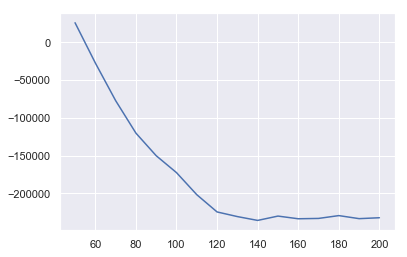

In [21]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

可以看到大约 n = 140 的时候， AIC是最小的，因此我们打算使用这个n_components = 140 的模型，并且确认其是否收敛

In [22]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [23]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

通过PCA对象的逆变换来构建新的数字

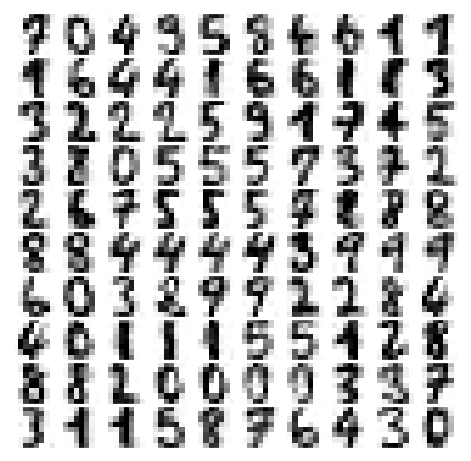

In [24]:
digits_new=pca.inverse_transform(data_new)
plot_digits(digits_new)

简单总结：
* 获得手写示例
* 对手写示例在几乎不损失信息的情况下降维
* 对降维后的数据，用GMM做密度估计，并确认收敛
* sample出新的点
* 利用降维方法的逆变换得到新的手写数据